# Case Study: Marianne Clary

# # Importation and observation of the data



First, I import all the modules I will need

In [27]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from scipy import signal
from scipy.signal import butter, lfilter
import pandas as pd
import mne 
import tsfresh.feature_extraction.feature_calculators as fc
from scipy.stats import skew, kurtosis
from scipy import signal, integrate
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import itertools
from itertools import compress


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel

In [7]:
#Useful fonctions

def butter_bandpass(lowcut:float, highcut:float, fs:float, order:int=4):
    """
    Return a bandpass filter on [lowcut,highcut] band
    lowcut: Lower bound of the filter, in hz
    highcut: Higher bound of the filter, in hz
    fs: frequency of the signal, in hz
    order: order of the filter, higher order will result in stronger regularization
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut:float, highcut:float, fs:float, order:int=4):
    """
    Apply a bandpass filtering on [lowcut,highcut] band on the provided data
    data: 1D numpy array
    lowcut: Lower bound of the filter, in hz
    highcut: Higher bound of the filter, in hz
    fs: frequency of the signal, in hz
    order: order of the filter, higher order will result in stronger regularization
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [2]:
#Useful information to import the data


# List of the records included in the case study
records_list =  [
"8e0bf011-1db6-46fa-a3cd-496e60c0de6f",
"d8a9babd-8454-42e9-9286-eb66c996d3e6",
"c5080eac-a388-4b1f-818f-a7f902fe4c06",
"62492470-d4d5-4dee-8030-80cca44fb002",
"87748119-6fff-45d2-9219-888532fb7efd",
"9bd9224a-bbdf-46c2-a494-3bbfcfd7e776",
"8f3dc41c-df99-4a5f-82cf-6b9f6e265b92"
]

#Path of the data, needs to be changed 
PATH_TO_DATA = Path.cwd()/'h5'
PATH_TO_HYPNOGRAM = Path.cwd()/'hypnograms'


# Signals sampling rate in Hz
EEG_FREQUENCY = 250
ACCELEROMETER_FREQUENCY = 50
SLEEP_STAGE_ENCODING = {
    "WAKE":0,
    "N1":1,
    "N2":2,
    "DEEP":3,
    "REM":4
}


SIGNALS_DESCRIPTION = [
    {'path':'accelerometer_x','fs':ACCELEROMETER_FREQUENCY},
    {'path':'accelerometer_y','fs':ACCELEROMETER_FREQUENCY},
    {'path':'accelerometer_z','fs':ACCELEROMETER_FREQUENCY},
    {'path':'eeg1','fs':EEG_FREQUENCY},
    {'path':'eeg2','fs':EEG_FREQUENCY},
    {'path':'eeg3','fs':EEG_FREQUENCY},
    {'path':'eeg4','fs':EEG_FREQUENCY},
    {'path':'eeg5','fs':EEG_FREQUENCY},
    {'path':'eeg6','fs':EEG_FREQUENCY},
    {'path':'eeg7','fs':EEG_FREQUENCY},
]


I visualize some data to have an idea of their format, their value and to have an idea of their quality 

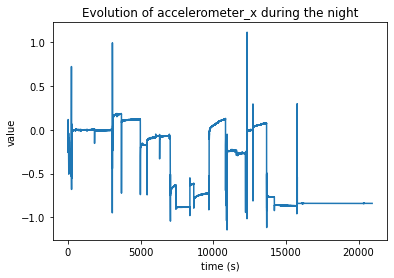

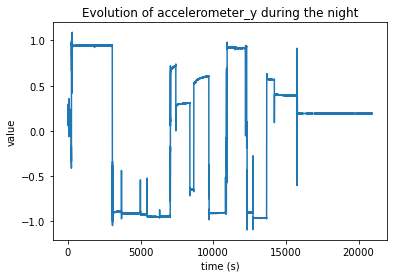

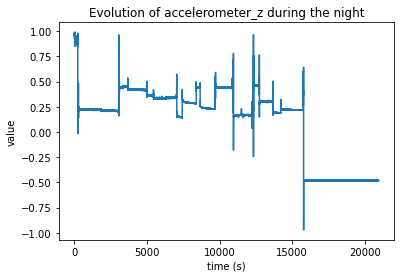

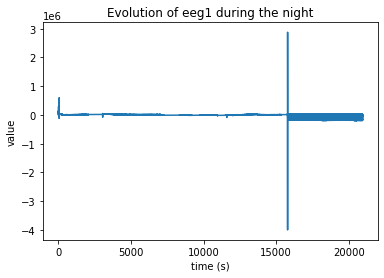

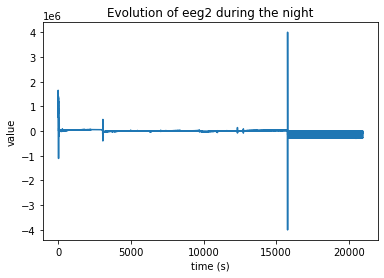

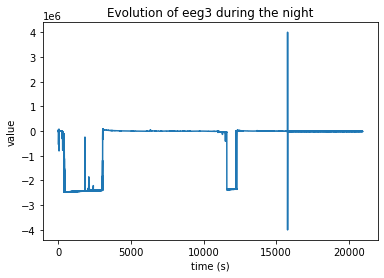

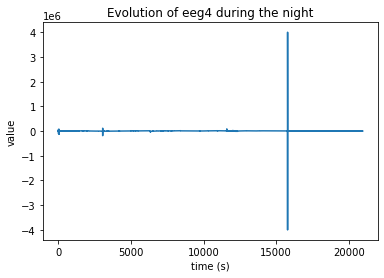

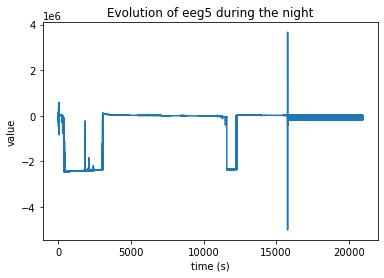

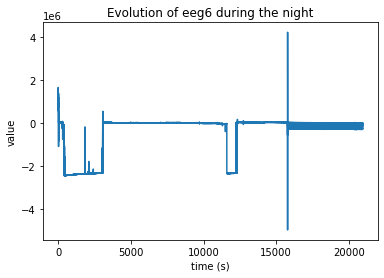

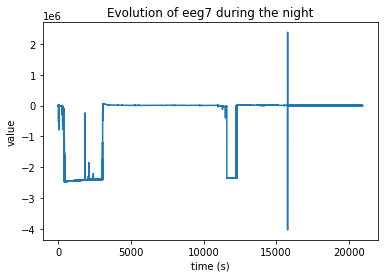

In [5]:
record_data = h5py.File(PATH_TO_DATA / f"{records_list[6]}.h5",'r')
with open(PATH_TO_HYPNOGRAM / f"{records_list[6]}.json",'r') as hypnogram_file:
    hypnogram = json.load(hypnogram_file)



for raw_signal in SIGNALS_DESCRIPTION:
    signal_data = record_data[raw_signal['path']][:]
    plt.title(f"Evolution of {raw_signal['path']} during the night")
    plt.plot(np.arange(0,signal_data.shape[0]) / raw_signal['fs'], signal_data)
    plt.xlabel('time (s)')
    plt.ylabel('value')
    plt.show()

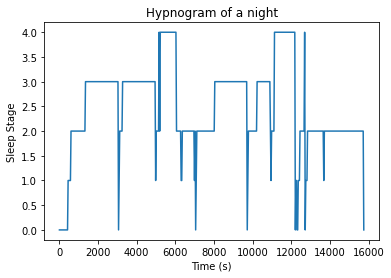

In [6]:
encoded_hypnogram = [SLEEP_STAGE_ENCODING[x] for x in hypnogram]
plt.title("Hypnogram of a night")
plt.plot(np.arange(0,len(encoded_hypnogram)) * 30, encoded_hypnogram)
plt.xlabel('Time (s)')
plt.ylabel("Sleep Stage")
plt.show()

These are raw experimental data, so they are relatively noisy. I suggest to preprocess it by making a spectral analysis and keeping only the frequencies containing the true information of the signal
I also noticed that the data corresponding to the last night had an anomaly. Indeed, I noticed that the end of the eeg and accelerometer data, from about 16000 seconds, were not relevant anymore. Moreover it is around this timing that the hypnogram stops, it will be necessary to take it into account.

I then decided to put all the data in a DataFrame in order to keep them in order and to cut them by 30 seconds sections in order to link them to the corresponding hypnogram step.

In [10]:
#Lists creation

y_train=[]
T=[]

raw_data=pd.DataFrame()

for record in records_list:
    record_data = h5py.File(PATH_TO_DATA / f"{record}.h5",'r')
    with open(PATH_TO_HYPNOGRAM / f"{record}.json",'r') as hypnogram_file:
        hypnogram = json.load(hypnogram_file)
        #Implementation of y_train by attaching each hypnogram
        y_train+=hypnogram
        
    for raw_signal in SIGNALS_DESCRIPTION:
        x= record_data[raw_signal['path']][:]
        fs=raw_signal['fs']
        
        if fs==250:
            x=butter_bandpass_filter(x,0.5,35,250,4) #When it's an eeg, I do a spectral filtering to denoise it
            
        x=x[0:len(hypnogram)*30*fs] # I cut the data so that they have the same duration as the hypnograms.
        #It's a bit barbaric, with more time I would have found a way to do it more cleanly, 
        #but after my observation of the data here, it should do the trick
        
        x2=np.reshape(x,(len(hypnogram),30*fs)) 
        T.append(x2)
        


for i in range(0,7):
    liste=[T[j].tolist() for j in range(10*i,10*(i+1))]
    temporary=pd.DataFrame(liste)
    temporary=temporary.transpose()
    raw_data=pd.concat([raw_data,temporary],ignore_index=True) # The DataFrame is called "Raw_data" but they're not
                                     

raw_data=raw_data.rename(columns = { 0: 'acc_x', 1: 'acc_y', 2: 'acc_z', 3: 'eeg1',
                           4: 'eeg2', 5: 'eeg3', 6: 'eeg4', 7: 'eeg5'
                           , 8: 'eeg6', 9: 'eeg7'})



for i in range(len(y_train)):
    y_train[i]=SLEEP_STAGE_ENCODING[y_train[i]]

In [15]:
raw_data


acc_x  \
0     [-0.3209228515625, -0.3212890625, -0.322753906...   
1     [-0.14996337890625, -0.15020751953125, -0.1502...   
2     [-0.84954833984375, -0.84930419921875, -0.8468...   
3     [-0.202392578125, -0.202392578125, -0.20220947...   
4     [-0.05438232421875, -0.01861572265625, 0.01800...   
...                                                 ...   
5462  [-0.86590576171875, -0.86614990234375, -0.8661...   
5463  [-0.866943359375, -0.8668212890625, -0.8667602...   
5464  [-0.86651611328125, -0.8665771484375, -0.86669...   
5465  [-0.86749267578125, -0.86737060546875, -0.8668...   
5466  [-0.9112548828125, -0.9111328125, -0.916687011...   

                                                  acc_y  \
0     [0.9202085733413696, 0.925523579120636, 0.9262...   
1     [0.9268330335617065, 0.9266921877861023, 0.926...   
2     [0.2924015522003174, 0.2921248972415924, 0.295...   
3     [0.9268937706947327, 0.9268467426300049, 0.927...   
4     [0.3518233895301819, 0.33290132880210876, 0.31...   
...                                                 ...   
5462  [0.39313140511512756, 0.39291757345199585, 0.3...   
5463  [0.3900911808013916, 0.39010173082351685, 0.39...   
5464  [0.3911604583263397, 0.3912074863910675, 0.391...   
5465  [0.3908115029335022, 0.3906811773777008, 0.391...   
5466  [0.0835077315568924, 0.08455592393875122, 0.08...   

                                                  acc_z  \
0     [0.2438654750585556, 0.2394346445798874, 0.236...   
1     [0.32577812671661377, 0.32598668336868286, 0.3...   
2     [0.46366286277770996, 0.46460139751434326, 0.4...   
3     [0.2967016100883484, 0.29700925946235657, 0.29...   
4     [0.7410076856613159, 0.7353547215461731, 0.731...   
...                                                 ...   
5462  [0.21706874668598175, 0.21712082624435425, 0.2...   
5463  [0.21739114820957184, 0.21700528264045715, 0.2...   
5464  [0.2164163440465927, 0.21610869467258453, 0.21...   
5465  [0.21505522727966309, 0.2148779034614563, 0.21...   
5466  [0.3491150438785553, 0.34891200065612793, 0.34...   

                                                   eeg1  \
0     [2761.9266626005383, 18521.848426415483, 57857...   
1     [-159.25803777802514, 397.98673762680875, 504....   
2     [32123.225199080513, 27865.79846230829, 30986....   
3     [-239.8417701334896, -666.4663272045497, -777....   
4     [3519.70344672628, 2300.398753280809, 1272.783...   
...                                                 ...   
5462  [-1.9958508928557421, -0.7223184979679331, -3....   
5463  [-23.131600969919333, -22.136716648180027, -24...   
5464  [-7.654415082622023, -3.302388808822286, -1.88...   
5465  [-4.655347210354137, -2.3505444155146336, -1.4...   
5466  [26.013691417998842, 29.307165696410323, 32.20...   

                                                   eeg2  \
0     [2729.734093446105, 18258.227508730004, 56942....   
1     [202.0655200691299, 619.8902264662463, 246.683...   
2     [-44999.12706243877, -44970.511695298264, -453...   
3     [-246.90959488790782, -389.84646076224226, -14...   
4     [-4893.6283257857585, -4977.193966002236, -501...   
...                                                 ...   
5462  [8.574958094941508, 33.41529665850737, 19.0456...   
5463  [-47.46566112047606, -26.298388813964664, -43....   
5464  [13.837561143524056, 39.54894412492075, 29.495...   
5465  [28.431290794590893, 62.60130107688548, 71.576...   
5466  [-340.1467112832644, -378.68210255254036, -405...   

                                                   eeg3  \
0     [-2457.760910038583, -16422.730481298222, -511...   
1     [-2.3170552504670923, -761.3521696532698, -477...   
2     [1305.3824645493878, 1117.39136281188, 742.865...   
3     [355.72968859926186, 685.8326478870149, 433.15...   
4     [258186.03794381695, 258642.26136250244, 25898...   
...                                                 ...   
5462  [-8.38206395151795, -8.390417676894657, -8.166...   
5463  [23.893559364765068, 23.812

So there are 5467 epochs of 30 seconds to characterize. The eeg boxes contain each 7500 values (30*250) and the accelerometer boxes 1500.

In [19]:
columns_names = ['acc_x',
                 'acc_y',
                 'acc_z',
                 'eeg1',
                 'eeg2',
                 'eeg3',
                 'eeg4',
                 'eeg5',
                 'eeg6',
                 'eeg7' ] 

# # Extraction and Selection of the features


I have chosen to calculate the following features in order to remain exhaustive and characterize each signal (eeg as accelerometer)

- Mean value
- Median
- Variance
- Absolute energy
- Skewness
- First quantile
- Last quantile
- Linear trend
- Kurtosis (flattening)
- Entropy
- Numbercrossing-m (Number of zeros)

First, I start to define all the functions that will calculate these values so that the code becomes more readable.This is relatively simple because all these calculations are found in the module tsfresh.feature_extraction.feature_calculators

In [20]:
def mean(x):
    return(fc.mean(x))


def variance(x):
    return(fc.variance(x))


def median(x):
    return(fc.median(x))


def abs_energy(x):
    return(fc.abs_energy(x))


def first_quantile(x):
    return(fc.quantile(x, 0.25))


def last_quantile(x):
    return(fc.quantile(x, 0.75))


def linear_trend(x, param=[{"attr": "stderr"}]):
    return(fc.linear_trend(x, param=param)[0][1])
# the kurtosis of x (calculated with the adjusted Fisher-Pearson standardized moment coefficient G2).


def binned_entropy(x, param=30):
    return(fc.binned_entropy(x, max_bins=param))


def number_crossing_m(x, param=0):
    return(fc.number_crossing_m(x, m=param))



In [21]:
# This is the function that will take all the others and apply it to a DataFrame to get the corresponding features

def main_features(data): 
    """" Returns new dataset with extracted features from standard statistics (will be applied to train and test datasets) """
    
    new_dataset = pd.DataFrame()
    
    for col_name in columns_names: 
        print("Computing the standard statistics for", col_name)
        #x = pd.Series(data[col_name])
        x = data[col_name]
        mean_ = np.mean(x.tolist(),axis=1)
        median_ = np.median(x.tolist(),axis=1)
        max_ = np.max(x.tolist(),axis=1)
        min_ = np.min(x.tolist(),axis=1)
        std_ = np.std(x.tolist(),axis=1) 
        skew_ = skew(x.tolist(),axis=1)
        kurtosis_ = kurtosis(x.tolist(),axis=1)
        first_quantile_ = x.apply(first_quantile)
        last_quantile_ = x.apply(last_quantile)
        abs_energy_ = x.apply(abs_energy)
        linear_trend_ = x.apply(linear_trend)
        binned_entropy_ = x.apply(binned_entropy)
        number_crossing_m_ = x.apply(number_crossing_m)

        


        new_list = list(map(lambda string :string +col_name, ["mean_","max_","min_","std_", 'median_', 'abs_energy_',"skew_","kurtosis_", 'first_quantile_', 'last_quantile_',
               'linear_trend_', 'binned_entropy_', 'number_crossing_m_']))
        new_cols = pd.DataFrame(dict(zip(new_list,(mean_,max_,min_,std_, median_, abs_energy_, skew_, kurtosis_, first_quantile_, last_quantile_, linear_trend_, binned_entropy_, 
                                                   number_crossing_m_))))
        new_dataset = pd.concat([new_dataset,new_cols],axis=1)
    
    return new_dataset


The eeg are characterized by their different waves, Delta waves. - Theta waves. - Alpha waves. - Beta waves. - Gamma waves. So I looked for what could be the features related to these waves After some research I decided to calculate the relative power of these frequency bands

In [22]:
eeg_bands = {'Delta': (0.0001, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 22),
             'Gamma': (22, 24.99)}


In [30]:
def welch_band_pow(x,fs,bands=list(eeg_bands.values())):
    """ Computes the relative powers in each frequency band of the dataframe x (one column of the dataset)
        Returns a list of 5 arrays, each one corresponds to the relative powers for each frequency band.
        This is applied only to the EEG signals."""
    
    res  = [] 
    f, powers = signal.welch(x.tolist(), fs,axis=1)
    # Frequency resolution
    df = f[1] - f[0]
    total_power = integrate.simps(powers, dx=df) # I integrate the power density using Simpson's method to get the total density
    
    for band in bands: # computing the relative powers
        idx_freq = np.logical_and(f >= band[0], f <= band[1]) # finding the frequencies in the band pass
        if (np.sum(idx_freq) == 0): # no frequencies in the selected band
            rel_power = np.zeros(np.shape(powers[:,0]))
        else :
            rel_power = integrate.simps(powers[:,idx_freq], dx=df)
        res.append(rel_power)
        
    return res

def welch_pow(x,fs):
    """ Computes total power for the accelerometer and the oximeter signals """
    
    f, powers = signal.welch(x.tolist(), fs, axis=1)
    df = f[1] - f[0]
    total_power = integrate.simps(powers, dx=df)

    return total_power 

def rel_power_feature(data):
    """ Computes the relative powers of each signal for each column """
    
    power_feat = pd.DataFrame()
    for col_name in columns_names: 
        
        print("Computing relative powers for", col_name)
        x = data[col_name]
        
        if col_name[:3] == "eeg":
            fs = 250
            rel_powers_band = welch_band_pow(x,fs)
            for i in range(5):
                name = "rel_power_"+ list(eeg_bands.keys())[i] +"_"+col_name
                power_feat = pd.concat([power_feat,pd.Series(rel_powers_band[i],name=name)],axis=1)
        else : 
            fs = 50 
            tot_power = welch_pow(x,fs)
            name = "total_power_"+col_name
            power_feat = pd.concat([power_feat,pd.Series(tot_power,name=name)],axis=1)
    return power_feat



In [31]:
def complete_features(data):
    """ Getting all the features from a dataset """
    
    standard_feat = main_features(data)
    power_feat = rel_power_feature(data)
    total_feat = pd.concat([standard_feat,power_feat],axis=1)
    return total_feat

In [32]:
features_df = complete_features(raw_data)

Computing the standard statistics for acc_x
Computing the standard statistics for acc_y
Computing the standard statistics for acc_z
Computing the standard statistics for eeg1
Computing the standard statistics for eeg2
Computing the standard statistics for eeg3
Computing the standard statistics for eeg4
Computing the standard statistics for eeg5
Computing the standard statistics for eeg6
Computing the standard statistics for eeg7
Computing relative powers for acc_x
Computing relative powers for acc_y
Computing relative powers for acc_z
Computing relative powers for eeg1
Computing relative powers for eeg2
Computing relative powers for eeg3
Computing relative powers for eeg4
Computing relative powers for eeg5
Computing relative powers for eeg6
Computing relative powers for eeg7


In [33]:
features_df


mean_acc_x  max_acc_x  min_acc_x  std_acc_x  median_acc_x  \
0      -0.195697  -0.149414  -0.753845   0.102416     -0.155090   
1      -0.518696  -0.146423  -0.880737   0.262696     -0.685669   
2      -0.539404  -0.201782  -1.033264   0.326316     -0.341553   
3      -0.203050  -0.092102  -0.700317   0.077331     -0.187347   
4      -0.809786   0.601624  -0.955017   0.401435     -0.950378   
...          ...        ...        ...        ...           ...   
5462   -0.866764  -0.864685  -0.868469   0.000473     -0.866821   
5463   -0.866994  -0.865906  -0.868286   0.000375     -0.867004   
5464   -0.866913  -0.865723  -0.868225   0.000386     -0.866882   
5465   -0.869127  -0.865356  -0.917847   0.009195     -0.866821   
5466   -0.739612   0.297607  -0.958191   0.239442     -0.795044   

      abs_energy_acc_x  skew_acc_x  kurtosis_acc_x  first_quantile_acc_x  \
0            73.179338   -3.324964       11.707299             -0.177979   
1           507.081482    0.636351       -1.468906             -0.694290   
2           596.158664   -0.437260       -1.605824             -0.973892   
3            70.813743   -4.839090       23.169012             -0.196228   
4          1225.356222    2.714357        5.714552             -0.950684   
...                ...         ...             ...                   ...   
5462       1126.919758    0.466293        1.606476             -0.867004   
5463       1127.517201   -0.333742        0.444636             -0.867188   
5464       1127.306190   -0.089186        0.057316             -0.867188   
5465       1133.200696   -4.005397       14.599528             -0.867126   
5466        906.538696    2.406743        5.572826             -0.897675   

      last_quantile_acc_x  ...  rel_power_Delta_eeg6  rel_power_Theta_eeg6  \
0               -0.151978  ...          1.098623e+08          1.952459e+06   
1               -0.149536  ...          1.487383e+08          3.583402e+05   
2               -0.248505  ...          8.972609e+08          4.567726e+06   
3               -0.178635  ...          4.733873e+08          4.196892e+05   
4               -0.949829  ...          4.128565e+10          5.154928e+09   
...                   ...  ...                   ...                   ...   
5462            -0.866516  ...          4.049078e+02          8.498676e+01   
5463            -0.866760  ...          4.452365e+02          8.428074e+01   
5464            -0.866638  ...          4.173027e+02          8.830264e+01   
5465            -0.866577  ...          8.064312e+03          1.997274e+02   
5466            -0.729233  ...          4.833027e+10          3.440842e+09   

      rel_power_Alpha_eeg6  rel_power_Beta_eeg6  rel_power_Gamma_eeg6  \
0             2.113502e+05         5.087424e+04          1.135070e+03   
1             2.804250e+04         1.008407e+04          2.237806e+02   
2             2.695001e+05         1.032968e+05          5.995213e+03   
3             2.770813e+04         7.818850e+03          3.155709e+02   
4             1.804443e+09         1.560650e+09          1.066773e+08   
...                    ...                  ...                   ...   
5462          1.473004e+01         9.529606e+00          5.846139e-01   
5463          1.648922e+01         1.027871e+01          5.899130e-01   
5464          1.489848e+01         1.086559e+01          6.083652e-01   
5465          3.785205e+01         1.516176e+01          1.156505e+00   
5466          3.502030e+08         2.642940e+08          2.138584e+07   

      rel_power_Delta_eeg7  rel_power_Theta_eeg7  rel_power_Alpha_eeg7  \
0             1.043264e+08          3.558640e+06          8.888578e+05   
1             1.153197e+08          1.790065e+05          1.909042e+04   
2             7.276535e+08          2.660573e+06          1.912253e+05   
3             4.804129e+08          4.265626e+05          2.764493e+04   
4             3.084868e+10          2.885353e+09          6.521767e+08   
...                    ...    

For the moment I have 168 different features, in order to shorten the computation time I will make a selection of the features really useful for the classification. For that, I will start by normalizing the features in order to compare them between them

In [34]:
def normalize_data(data):
    scaler = preprocessing.QuantileTransformer(output_distribution='normal')
    df_norm = pd.DataFrame(scaler.fit_transform(data.values))
    df_norm.columns=data.columns
    return(df_norm)

In [35]:
df_norm = normalize_data(features_df)

In [36]:
def features_select(df, y):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(df, y)
    feature_selection_model = SelectFromModel(clf, prefit=True)
    df_sub = pd.DataFrame(feature_selection_model.transform(df))
    columns = df.columns
    selected_col = feature_selection_model.get_support()
    df_sub.columns = list(compress(columns, selected_col))
    return df_sub, df_sub.columns

In [38]:
df_norm_sub , selected_features = features_select(df_norm, y_train)
print("On a donc {} features selectionnée".format(selected_features.shape[0]))
selected_features

On a donc 51 features selectionnée


Index(['mean_acc_x', 'max_acc_x', 'min_acc_x', 'linear_trend_acc_x',
       'kurtosis_acc_y', 'mean_acc_z', 'max_acc_z', 'std_acc_z',
       'kurtosis_acc_z', 'binned_entropy_acc_z', 'min_eeg1', 'std_eeg1',
       'abs_energy_eeg1', 'kurtosis_eeg1', 'first_quantile_eeg1',
       'last_quantile_eeg1', 'linear_trend_eeg1', 'binned_entropy_eeg1',
       'number_crossing_m_eeg1', 'min_eeg2', 'std_eeg2', 'abs_energy_eeg2',
       'first_quantile_eeg2', 'last_quantile_eeg2', 'number_crossing_m_eeg2',
       'number_crossing_m_eeg3', 'max_eeg4', 'min_eeg4', 'std_eeg4',
       'abs_energy_eeg4', 'first_quantile_eeg4', 'last_quantile_eeg4',
       'linear_trend_eeg4', 'binned_entropy_eeg4', 'number_crossing_m_eeg4',
       'first_quantile_eeg5', 'total_power_acc_z', 'rel_power_Delta_eeg1',
       'rel_power_Theta_eeg1', 'rel_power_Alpha_eeg1', 'rel_power_Gamma_eeg1',
       'rel_power_Delta_eeg2', 'rel_power_Gamma_eeg2', 'rel_power_Alpha_eeg3',
       'rel_power_Gamma_eeg3', 'rel_power_Delta_ee

# # Model training


For this classification I have chosen the RandomForest model

In [39]:
X_train_t, X_train_v, y_train_t, y_train_v = train_test_split(df_norm_sub, y_train, stratify=y_train, random_state=1)

In [40]:
clf = RandomForestClassifier(n_estimators=2500, criterion='gini', max_depth=None)

clf.fit(X_train_t, y_train_t)

predictions = clf.predict(X_train_v)

Model score

In [41]:
score_acc=accuracy_score(y_train_v, predictions)
score_prec=precision_score(y_train_v, predictions, average='macro')
score_f1=f1_score(y_train_v, predictions, average='macro')

In [42]:
print(score_acc,score_prec,score_f1)


0.8493050475493782 0.771156914939889 0.705225076248308


I got a score of 70% (f1 score) with this model. I didn't have time to optimize completely its parameters, normally I would have used a grid to browse the different potential parameter values.
On the other hand, I should also have left a "night" aside from the start to test my model on brand new data in order to validate it properly. 
I could also have tried different types of models (for example the KNeighbors).
Finally, I could also have done an analysis of the predictions, looking at the distribution of the sleep stages, establishing a confusion matrix etc...

